In [23]:
import tensorflow as tf
from keras import layers
from keras import activations
from keras import losses
from keras import optimizers
from keras import metrics
from keras.datasets import mnist
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train = x_train / 255.
x_test = x_test / 255.

In [4]:
x_train[0].shape

(28, 28)

In [5]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

x_train[0].shape

(28, 28, 1)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [45]:
class Classifier(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.conv = layers.Conv2D(32, 3, activation=activations.relu)
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(128, activation=activations.relu)
        self.dense2 = layers.Dense(10, activation=activations.softmax)

        self.loss_func = losses.SparseCategoricalCrossentropy(True)
        self.optimizer = optimizers.Adam()

        self.train_loss = metrics.Mean()
        self.test_loss = metrics.Mean()

        self.train_accuracy = metrics.SparseCategoricalAccuracy()
        self.test_accuracy = metrics.SparseCategoricalAccuracy()

    def call(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.dense1(x)

        return self.dense2(x)

    def build_model(self):
        self.model = Classifier()

    @tf.function
    def train(self, images, labels):
        # tape: tf.GradientTape
        with tf.GradientTape() as tape:
            pred = self.model(images)
            loss = self.loss_func(labels, pred)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(gradients, self.model.trainable_variables))

        self.train_loss(loss)
        self.train_accuracy(labels, pred)

    @tf.function
    def test(self, images, labels):
        pred = self.model(images)
        loss = self.loss_func(labels, pred)

        self.test_loss(loss)
        self.test_accuracy(labels, pred)

    def fit(self, train_dataset, test_dataset, epochs):
        for epoch in range(1, epochs + 1):
            self.train_loss.reset_states()
            self.train_accuracy.reset_states()
            self.test_loss.reset_states()
            self.test_accuracy.reset_states()

            for imgs, labels in train_dataset:
                self.train(imgs, labels)

            for imgs, labels in test_dataset:
                self.test(imgs, labels)

            show_train_loss = round(float(self.train_loss.result()), 4)
            show_train_acc = round(float(self.train_accuracy.result()), 4)
            show_test_loss = round(float(self.test_loss.result()), 4)
            show_test_acc = round(float(self.test_accuracy.result()), 4)
            print(f'Epoch: {epoch}, Train Loss: {show_train_loss}, Train Accuracy: {show_train_acc}, ' +
                  f'Test Loss: {show_test_loss}, Test Accuracy: {show_test_acc}')
    
    def predict(self, img):
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = cv.resize(img, (28, 28))

        # add new axis for model
        img = img[..., tf.newaxis]
        # add batch size
        img = img[tf.newaxis, ...]
        img = img.astype('float32')

        return self.model(img)
    
    def load_model(self, model_path):
        self.model = tf.keras.models.load_model(model_path)

In [49]:
model = Classifier()
model.build_model()
model.fit(train_dataset, test_dataset, 5)

Epoch: 1, Train Loss: 0.1314, Train Accuracy: 0.9596, Test Loss: 0.0595, Test Accuracy: 0.9804
Epoch: 2, Train Loss: 0.0415, Train Accuracy: 0.9872, Test Loss: 0.0564, Test Accuracy: 0.981
Epoch: 3, Train Loss: 0.0205, Train Accuracy: 0.9935, Test Loss: 0.0547, Test Accuracy: 0.9822
Epoch: 4, Train Loss: 0.013, Train Accuracy: 0.9956, Test Loss: 0.0668, Test Accuracy: 0.9826
Epoch: 5, Train Loss: 0.0093, Train Accuracy: 0.997, Test Loss: 0.0577, Test Accuracy: 0.9839


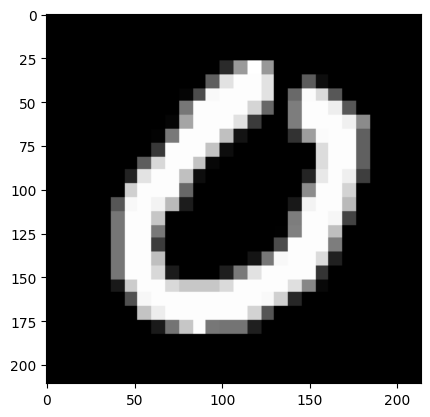

In [50]:
zero_img = cv.imread('./io/input/zero.png')
plt.imshow(zero_img, cmap='gray')
plt.show()

In [51]:
np.argmax(model.predict(zero_img))

0

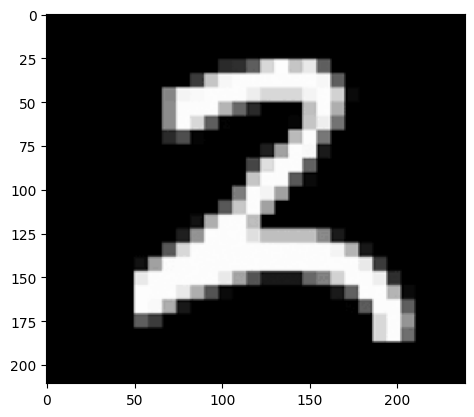

In [52]:
tow_img = cv.imread('./io/input/tow.png')
plt.imshow(tow_img, cmap='gray')
plt.show()

In [53]:
np.argmax(model.predict(tow_img))

2